In [30]:
# Built-in modules
import math
import warnings

warnings.filterwarnings("ignore")

# Imports from Qiskit
from qiskit import QuantumCircuit
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.visualization import plot_distribution

# Imports from Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler

In [31]:
def grover_oracle(marked_states):
    """Build a Grover oracle for multiple marked states

    Here we assume all input marked states have the same number of bits

    Parameters:
        marked_states (str or list): Marked states of oracle

    Returns:
        QuantumCircuit: Quantum circuit representing Grover oracle
    """
    if not isinstance(marked_states, list):
        marked_states = [marked_states]
    # Compute the number of qubits in circuit
    num_qubits = len(marked_states[0])

    qc = QuantumCircuit(num_qubits)
    # Mark each target state in the input list
    for target in marked_states:
        # Flip target bit-string to match Qiskit bit-ordering
        rev_target = target[::-1]
        # Find the indices of all the '0' elements in bit-string
        zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)]
        # Add a multi-controlled Z-gate with pre- and post-applied X-gates (open-controls)
        # where the target bit-string has a '0' entry
        qc.x(zero_inds)
        qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)
        qc.x(zero_inds)
    return qc

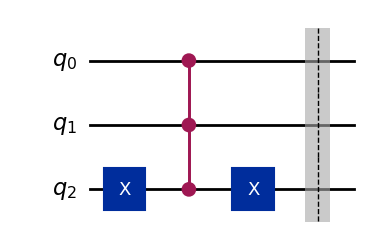

In [32]:
marked_states = ["011"]

oracle = grover_oracle(marked_states)
oracle.barrier()
oracle.draw(output="mpl", style="iqp")

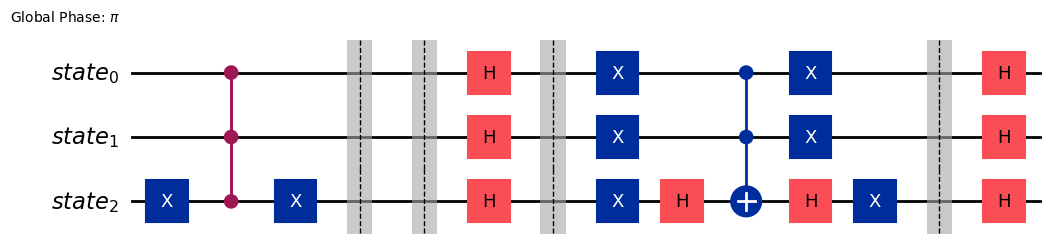

In [33]:
grover_op = GroverOperator(oracle, insert_barriers=True)
# grover_op.draw(output="mpl", style="iqp")
grover_op.decompose().draw(output="mpl", style="iqp")

In [34]:
optimal_num_iterations = math.floor(
    math.pi / (4 * math.asin(math.sqrt(len(marked_states) / 2**grover_op.num_qubits)))
)

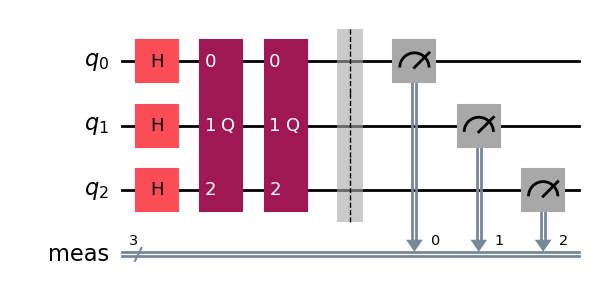

In [35]:
qc = QuantumCircuit(grover_op.num_qubits)
# Create even superposition of all basis states
qc.h(range(grover_op.num_qubits))
# Apply Grover operator the optimal number of times
qc.compose(grover_op.power(optimal_num_iterations), inplace=True)
# Measure all qubits
qc.measure_all()
qc.draw(output="mpl", style="iqp")

{'000': 16, '010': 13, '100': 18, '110': 11, '001': 15, '011': 1946, '111': 12, '101': 17}


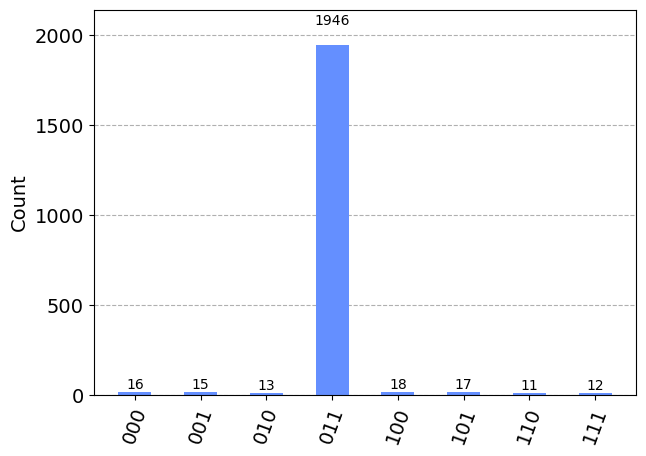

In [36]:
# To run on local simulator:
#   1. Use the SatetvectorSampler from qiskit.primitives instead

from qiskit import transpile 
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

backend = AerSimulator()

# Prvo prevedemo celotno vezje v low-level instrukcije za simulator
qc_compiled = transpile(qc, backend)

# Izvrednotimo vezje in naredimo 2048 ponovitev
job_sim = backend.run(qc_compiled, shots=2048)

# Grab the results from the job.
result_sim = job_sim.result()


counts = result_sim.get_counts(qc_compiled)
print(counts)

plot_histogram(counts)

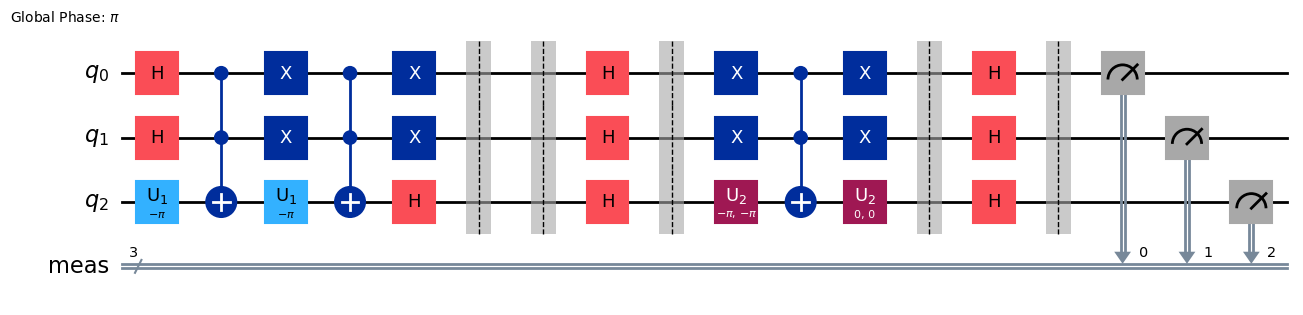

In [23]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

backend = AerSimulator()

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

circuit_isa = pm.run(qc)
circuit_isa.draw(output="mpl", idle_wires=False, style="iqp")